In [52]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
import xgboost as xgb
from xgboost_distribution import XGBDistribution
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
# client = bigquery.Client(project="ambient-sylph-426620-g6") # Odele

client = bigquery.Client(project="plucky-snowfall-438110-f2")

In [53]:
query = '''
    WITH purchases as(
        SELECT distinct
            fullVisitorId as user_id
            ,PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) AS datetime
            ,product.productSKU AS product_id
            ,product.v2ProductName AS product_name
            ,product.v2ProductCategory AS product_category
            ,product.productPrice/1000000 AS product_price
            ,product.productQuantity AS product_qty
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        LEFT JOIN UNNEST(hits.product) AS product ON TRUE
        WHERE true
            and hits.eCommerceAction.action_type  = '6'
            and product.productQuantity > 0
            and PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) < date '2017-08-01'
    )
    SELECT 
        date_trunc(datetime, day) as ymd
        ,product_id
        ,product_name
        ,product_category product_category_temp
        ,product_price
        ,sum(product_qty) as daily_qty
        ,count(distinct user_id) as daily_user_cnt
    FROM purchases
    GROUP BY 2,1,3,4,5
    ORDER BY 1,2,3
    
'''

rows = client.query(query)
daily_sales = rows.to_dataframe()
raw_ga_data = rows.to_dataframe()

## 1. Querying product sales from GA

In [55]:
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])
daily_sales.replace('(not set)', np.nan, inplace = True)
daily_sales['product_category_temp'].replace('${productitem.product.origCatName}', np.nan, inplace = True)
daily_sales['product_category_temp'].replace(['Tumblers', 'Bottles', 'Google'], 'Drinkware', inplace = True)
daily_sales['product_category_temp'].replace(['More Bags', 'Backpacks'], 'Bags', inplace = True)
daily_sales['product_category_temp'].replace('Android', 'Apparel', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"Waze.*(Men's|Women's|Socks)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales['product_category_temp'].replace('Waze', 'Office', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"(Shirt|Sleeve|Tee|Jacket|Pullover|Hoodie|Tank|Vest|Onesie|Pants|Hood|Polo)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales.loc[daily_sales["product_name"].str.contains(r"(oz|Bottle|Cup)", case = True, na = False), "product_category_temp"] = "Drinkware"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Journal|Notebook", case = True, na = False), "product_category_temp"] = "Notebooks & Journals"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Bag|Backpack|Tote|Rucksack", case = True, na = False), "product_category_temp"] = "Bags"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Gift Card", case = True, na = False), "v"] = "Gift Cards"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Electronics|Device|Headphones|Earbuds|Earphones", case = True, na = False), "product_category_temp"] = "Electronics"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Cap|Hat", case = True, na = False), "product_category_temp"] = "Headgear"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Pen", case = True, na = False), "product_category_temp"] = "Office"
daily_sales["product_id"] = daily_sales['product_id'].astype("string")
product_category_mode = daily_sales.groupby(["product_id", "product_price"])["product_category_temp"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name="product_category")
daily_sales = daily_sales.merge(product_category_mode, on = ["product_id", "product_price"], how = "left")
daily_sales = daily_sales.groupby(["ymd", "product_id", "product_price", "product_category"])[["daily_qty", "daily_user_cnt"]].sum().reset_index()

daily_sales.dropna(subset = ['product_category'], inplace = True)

## 2. Grouping by product category and date to get sales per day

In [57]:
# Grouping the sales data by product category and date
category_sales = daily_sales.groupby(['ymd', 'product_category']).agg(
    daily_qty_sum=('daily_qty', 'sum'),  # Sum of quantities sold per day
    avg_price=('product_price', 'mean')  # Average price per day
).reset_index()

# Displaying the first few rows
category_sales.head()


,ymd,product_category,daily_qty_sum,avg_price
0,2016-08-01,Accessories,1,4.990000
1,2016-08-01,Apparel,67,18.730741
2,2016-08-01,Bags,15,34.590000
3,2016-08-01,Drinkware,235,8.943529
4,2016-08-01,Electronics,73,17.841667


## 3. Calculating price and quantity change

In [59]:
# Calculating the percentage change in daily quantity sold and average price for each category
category_sales['pct_change_qty'] = category_sales.groupby('product_category')['daily_qty_sum'].pct_change()
category_sales['pct_change_price'] = category_sales.groupby('product_category')['avg_price'].pct_change()

# Dropping rows with NaN values that result from the first day in each category (no previous day to compare)
category_sales.dropna(subset=['pct_change_qty', 'pct_change_price'], inplace=True)

# Displaying the data with percentage changes
category_sales.head()


,ymd,product_category,daily_qty_sum,avg_price,pct_change_qty,pct_change_price
9,2016-08-02,Apparel,21,19.478889,-0.686567,0.039942
10,2016-08-02,Bags,4,20.926667,-0.733333,-0.395008
11,2016-08-02,Drinkware,178,4.490000,-0.242553,-0.497961
12,2016-08-02,Electronics,14,2.595000,-0.808219,-0.854554
15,2016-08-02,Lifestyle,49,2.398571,-0.234375,-0.252146


## 4. Calculating price elasticity

In [61]:
# Calculating price elasticity for each product category
category_sales['price_elasticity'] = category_sales['pct_change_qty'] / category_sales['pct_change_price']

# Display the data with elasticity values
category_sales[['ymd', 'product_category', 'pct_change_qty', 'pct_change_price', 'price_elasticity']].head()

,ymd,product_category,pct_change_qty,pct_change_price,price_elasticity
9,2016-08-02,Apparel,-0.686567,0.039942,-17.188991
10,2016-08-02,Bags,-0.733333,-0.395008,1.856502
11,2016-08-02,Drinkware,-0.242553,-0.497961,0.487093
12,2016-08-02,Electronics,-0.808219,-0.854554,0.945779
15,2016-08-02,Lifestyle,-0.234375,-0.252146,0.929521


## 5. Removing infinity values

In [63]:
# Step 1: Remove rows where 'price_elasticity' has infinite values
category_sales_clean = category_sales[~np.isinf(category_sales['price_elasticity'])]

# Step 2: Display the cleaned data
category_sales_clean[['ymd', 'product_category', 'pct_change_qty', 'pct_change_price', 'price_elasticity']].head()

,ymd,product_category,pct_change_qty,pct_change_price,price_elasticity
9,2016-08-02,Apparel,-0.686567,0.039942,-17.188991
10,2016-08-02,Bags,-0.733333,-0.395008,1.856502
11,2016-08-02,Drinkware,-0.242553,-0.497961,0.487093
12,2016-08-02,Electronics,-0.808219,-0.854554,0.945779
15,2016-08-02,Lifestyle,-0.234375,-0.252146,0.929521


## 6. Calculating Sum and Mean Price Elasticity for each Month

In [65]:
# Step 1: Convert the 'ymd' column to a monthly period (if not already in datetime format)
category_sales['ymd'] = pd.to_datetime(category_sales['ymd'])  # Ensure it's a datetime object
category_sales['month'] = category_sales['ymd'].dt.to_period('M')  # Converts date to 'YYYY-MM'

# Step 2: Group by 'month' and 'product_category', and calculate sum and mean of 'price_elasticity'
monthly_elasticity_summary = category_sales.groupby(['month', 'product_category']).agg(
    mean_price_elasticity=('price_elasticity', 'mean')  # Mean of price elasticity for each month and category
).reset_index()

# Step 3: Display the result
print(monthly_elasticity_summary)

       month      product_category  mean_price_elasticity
0    2016-08           Accessories                    NaN
1    2016-08               Apparel              74.736859
2    2016-08                  Bags              27.972884
3    2016-08             Drinkware              40.912189
4    2016-08           Electronics              -0.236992
..       ...                   ...                    ...
135  2017-07              Headgear                    NaN
136  2017-07            Housewares                    NaN
137  2017-07             Lifestyle               1.228165
138  2017-07  Notebooks & Journals              -49.05597
139  2017-07                Office               20.81582

[140 rows x 3 columns]


## 7. Cleaning price elasticity values

In [67]:
category_sales_clean = category_sales.dropna(subset=['price_elasticity'])
category_sales_clean = category_sales[~np.isinf(category_sales['price_elasticity'])]
# Convert 'ymd' to monthly period if not done yet
category_sales_clean['month'] = category_sales_clean['ymd'].dt.to_period('M')

# Group by 'month' and 'product_category' and calculate sum and mean of 'price_elasticity'
monthly_elasticity_summary = category_sales_clean.groupby(['month', 'product_category']).agg(
    mean_price_elasticity=('price_elasticity', 'mean')
).reset_index()
# Convert 'month' to string for plotting if needed
monthly_elasticity_summary['month'] = monthly_elasticity_summary['month'].astype(str)
# Ensure the columns used for plotting are numeric
monthly_elasticity_summary['mean_price_elasticity'] = pd.to_numeric(monthly_elasticity_summary['mean_price_elasticity'], errors='coerce')
print(monthly_elasticity_summary)


       month      product_category  mean_price_elasticity
0    2016-08           Accessories                    NaN
1    2016-08               Apparel              74.736859
2    2016-08                  Bags              27.972884
3    2016-08             Drinkware              40.912189
4    2016-08           Electronics              -0.236992
..       ...                   ...                    ...
134  2017-07              Headgear                    NaN
135  2017-07            Housewares                    NaN
136  2017-07             Lifestyle               1.228165
137  2017-07  Notebooks & Journals              -49.05597
138  2017-07                Office               20.81582

[139 rows x 3 columns]


## 8. Importing Synthetic Data and combining it with Original Data

In [77]:
# Load and preprocess synthetic data from CSV
synthetic_data = pd.read_csv(r"C:\DSA3101-Project\E-commerce-Performance-Analysis-and-Optimization\SubgroupB\cleaned_synthetic_v3.csv")

# Ensure the 'year_month' column is in datetime format and create 'month' column for grouping
synthetic_data['month'] = pd.to_datetime(synthetic_data['year_month']).dt.to_period('M')

# Group by 'product_category' and 'month', and calculate sum of quantities and average price
synthetic_data_grouped = synthetic_data.groupby(['product_category', 'month']).agg(
    daily_qty_sum=('present_total_qty', 'sum'),  # Sum of total quantities sold per month
    avg_price=('product_price', 'mean')          # Average price per month
).reset_index()

# Sort the grouped data by 'month' and 'product_category'
synthetic_data_grouped = synthetic_data_grouped.sort_values(by=['month', 'product_category'])
synthetic_data_grouped.head()

# Step 1: Rename columns in synthetic data to match the original format
synthetic_data_grouped.rename(columns={
    'avg_price': 'mean_price_elasticity'      # Rename 'avg_price' to 'mean_price_elasticity'
}, inplace=True)

# Step 2: Convert 'month' column to timestamp for both datasets (to avoid PeriodDtype errors)
synthetic_data_grouped['month'] = synthetic_data_grouped['month'].dt.to_timestamp()

# Step 3: Standardize the structure and select the relevant columns for concatenation
synthetic_data_grouped = synthetic_data_grouped[['month', 'product_category', 'mean_price_elasticity']]
monthly_elasticity_summary = monthly_elasticity_summary[['month', 'product_category', 'mean_price_elasticity']]

# Step 4: Concatenate the synthetic data (on top) with the original monthly elasticity summary
combined_data = pd.concat([synthetic_data_grouped, monthly_elasticity_summary], ignore_index=True)

# Convert the 'month' column to the 'YYYY-MM' format
combined_data['month'] = pd.to_datetime(combined_data['month']).dt.strftime('%Y-%m')

# Display the updated dataframe
combined_data.head()


,month,product_category,mean_price_elasticity
0,2016-03,Accessories,6.47
1,2016-03,Apparel,28.156942
2,2016-03,Bags,39.122973
3,2016-03,Drinkware,13.145333
4,2016-03,Electronics,33.685135


## 9. Plotting time series of price elasticity for each product category

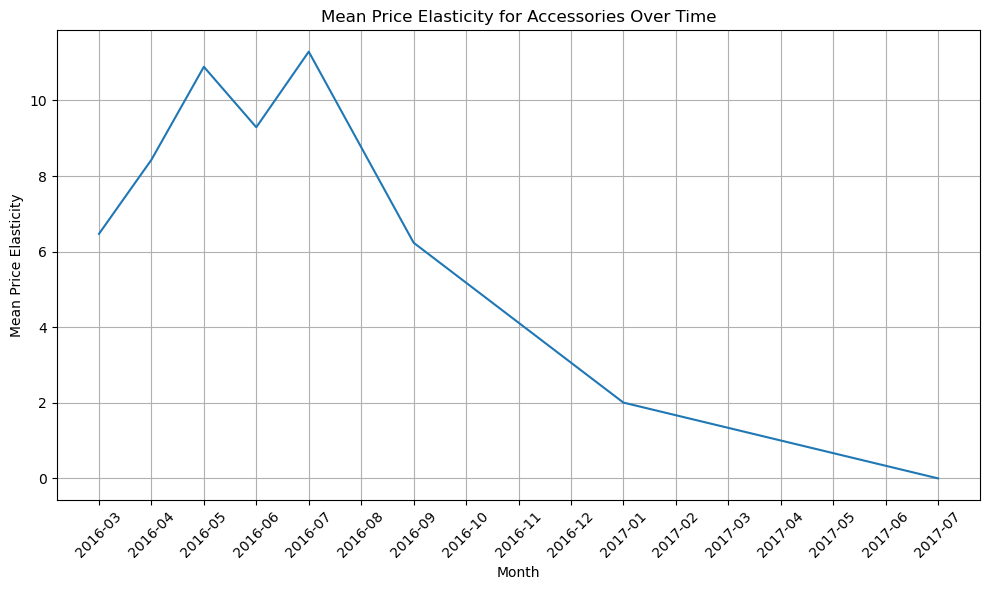

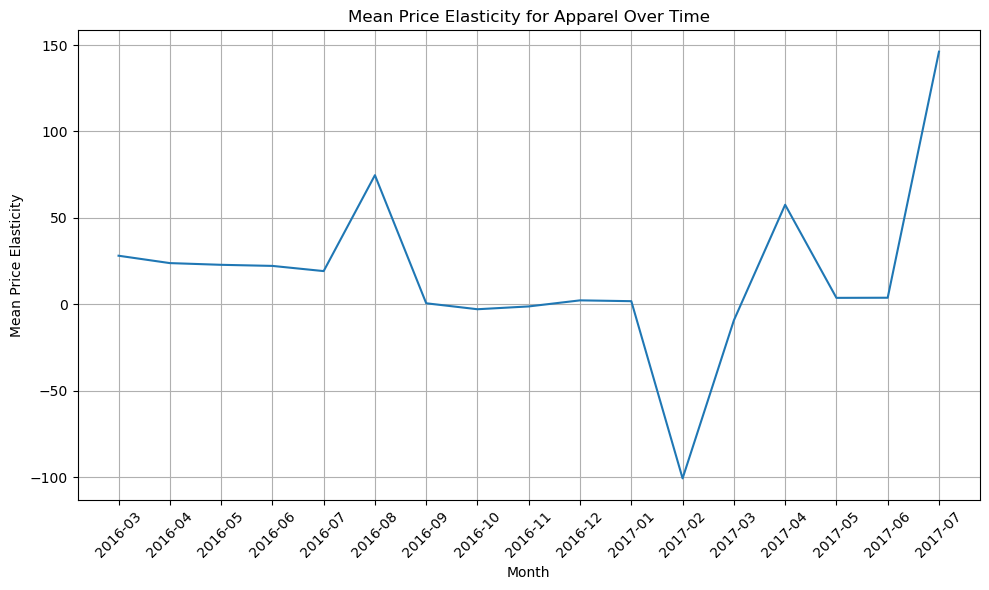

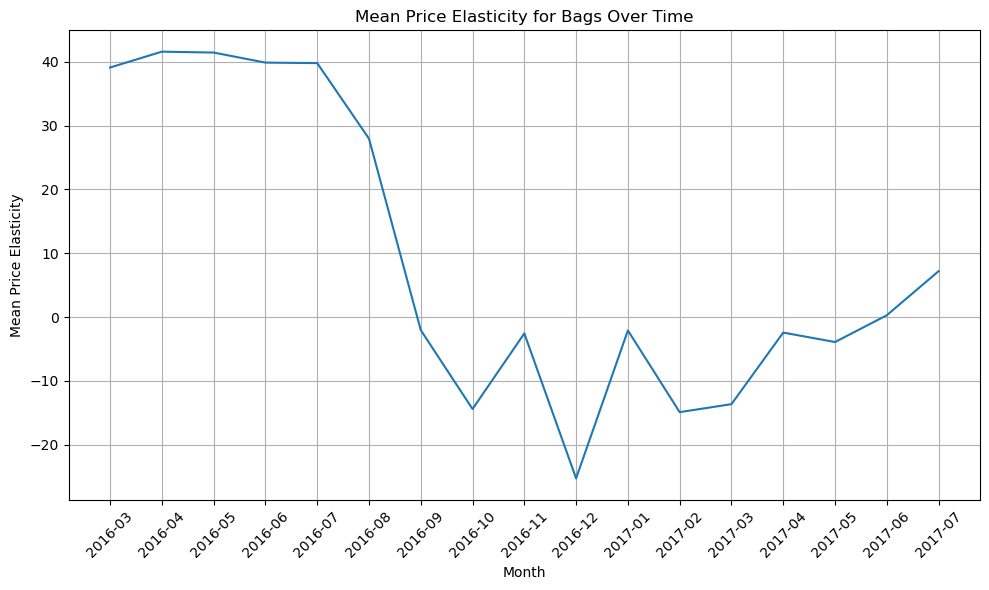

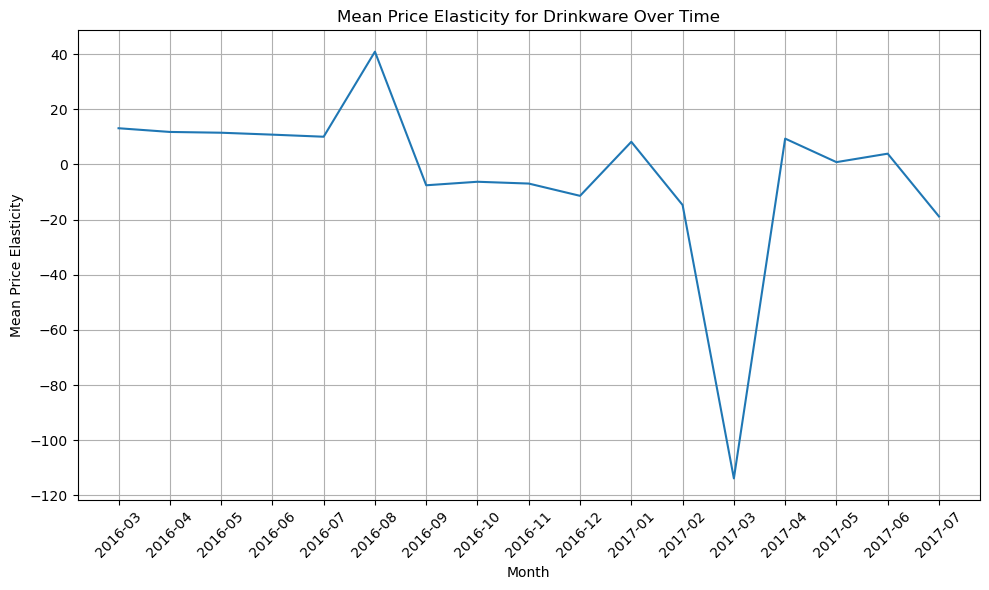

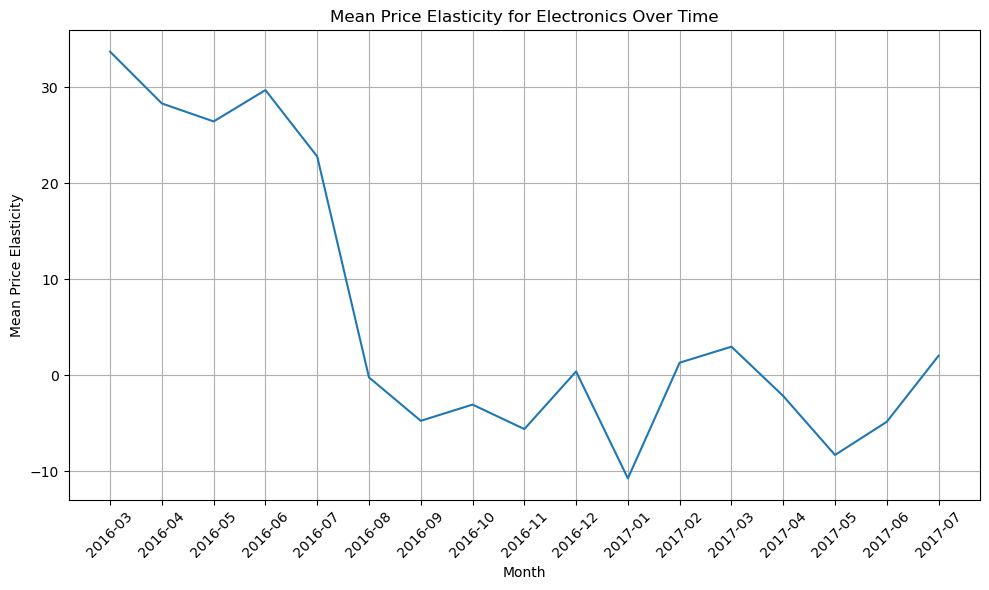

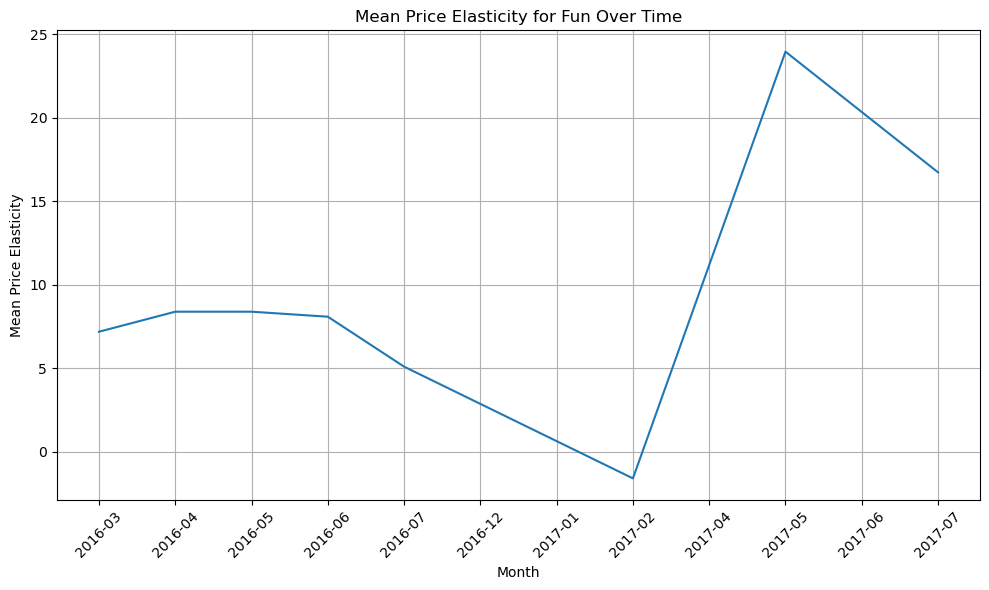

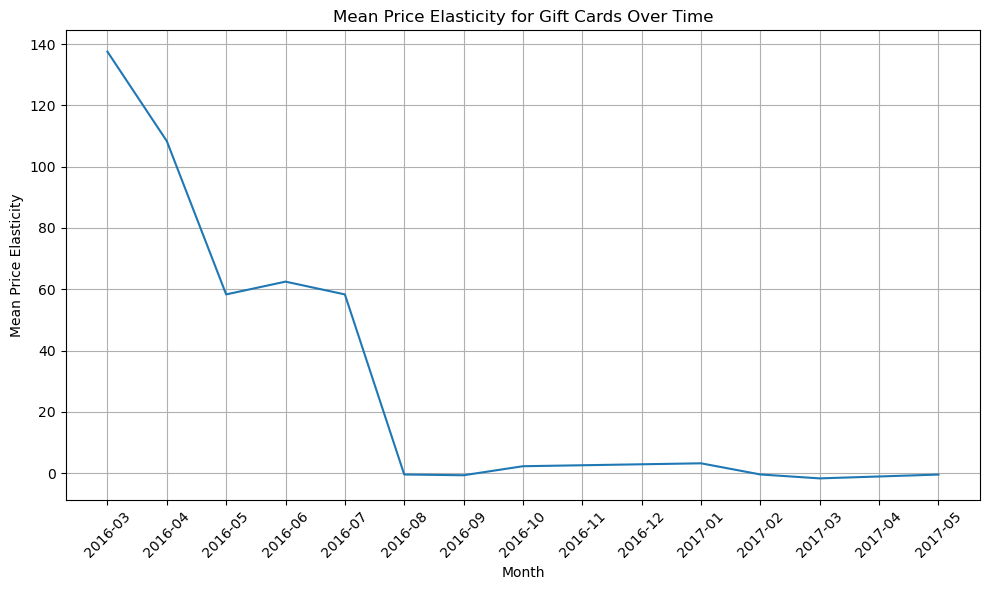

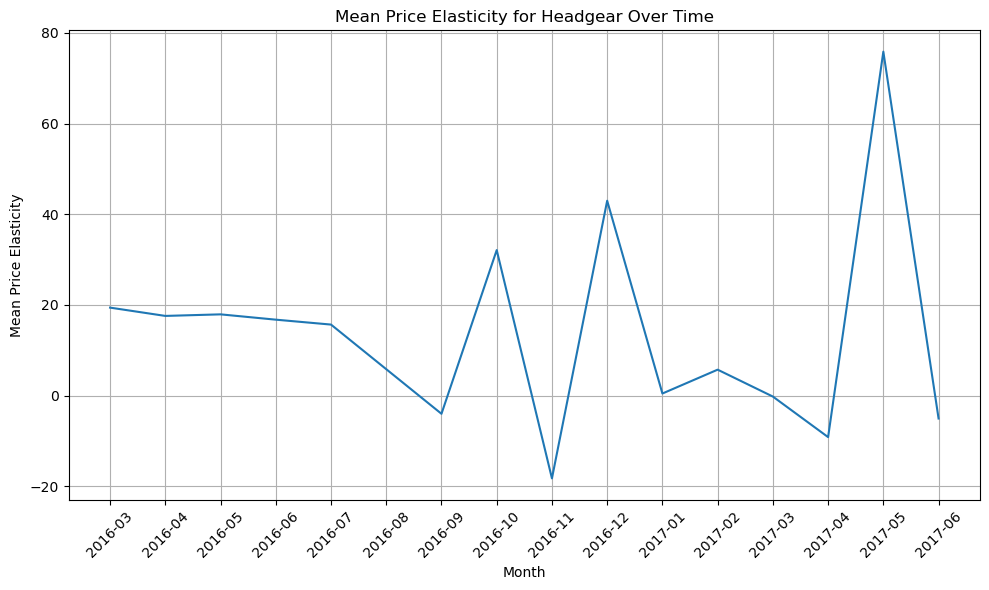

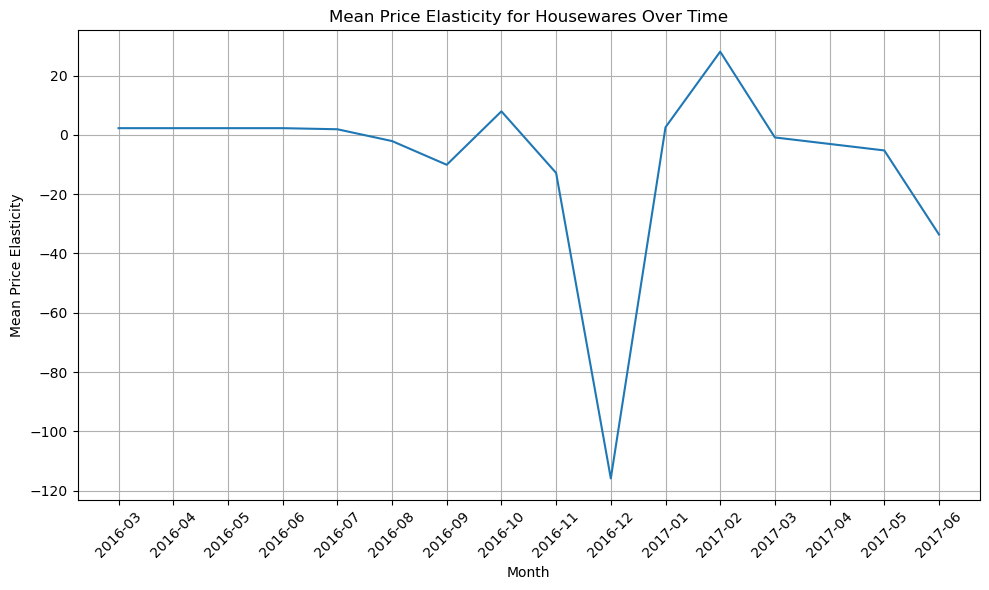

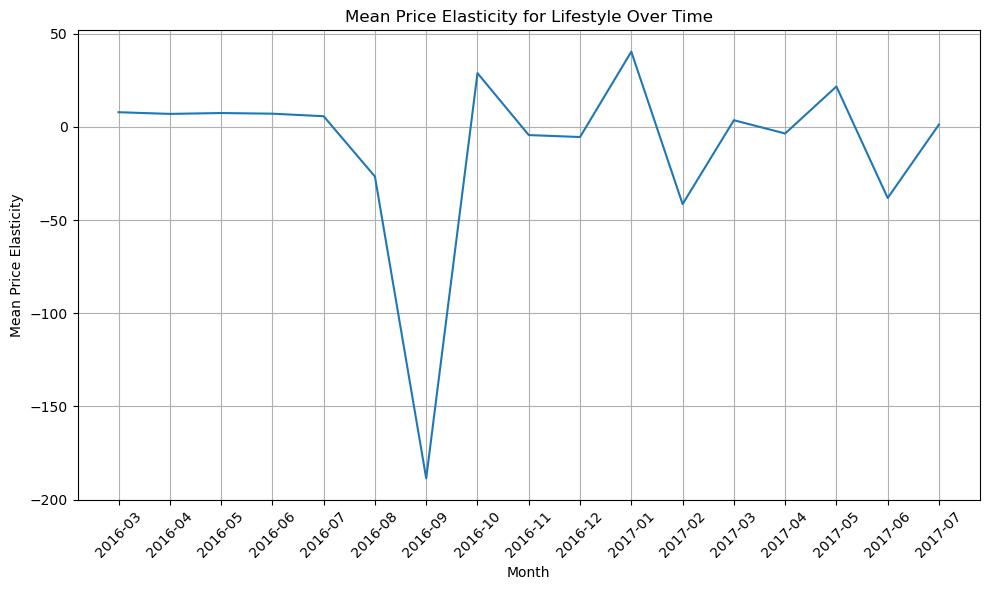

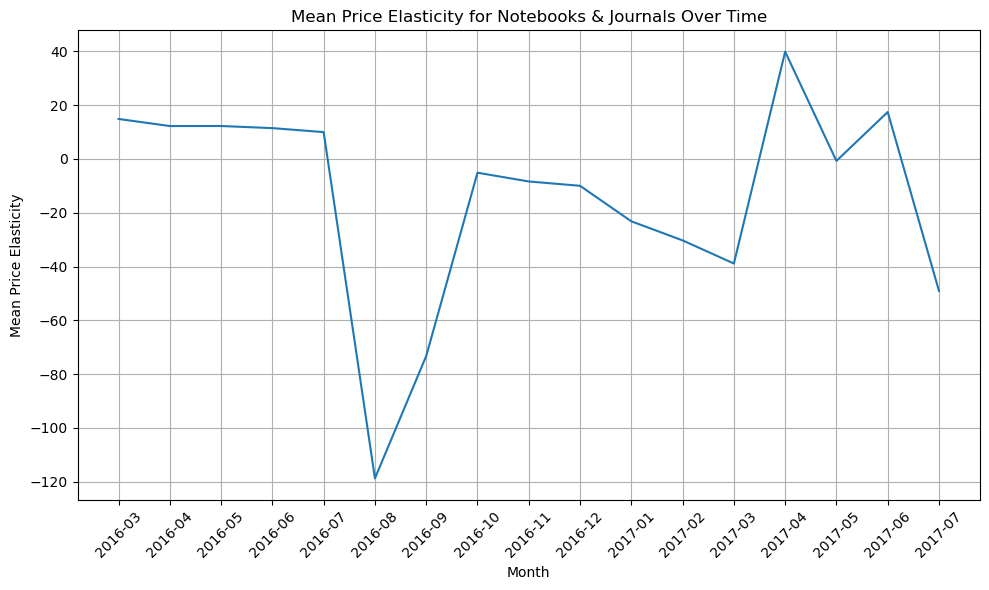

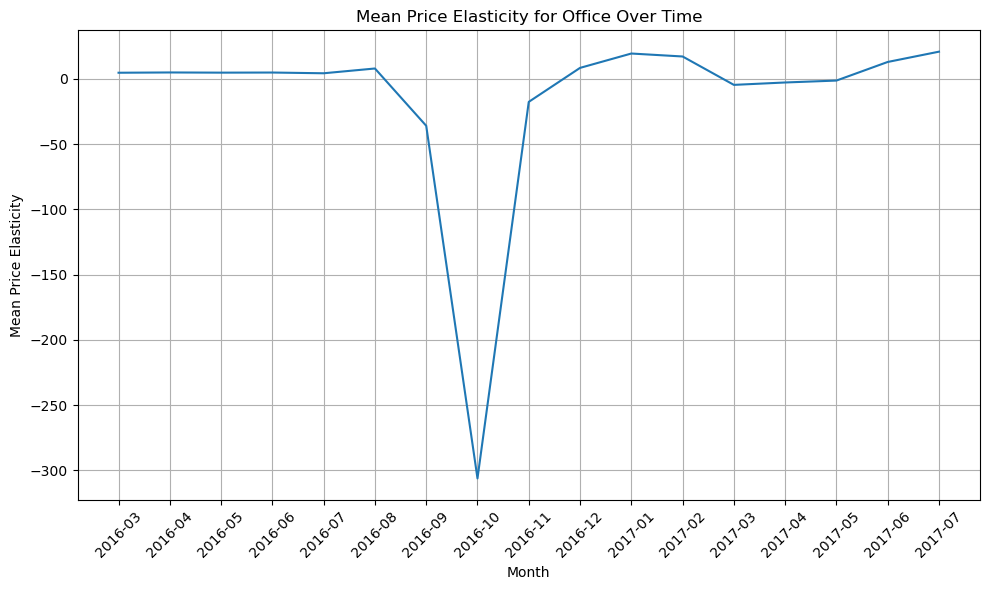

In [71]:
# Get unique product categories from the combined data
product_categories = combined_data['product_category'].unique()

# Plot each product category separately
for category in product_categories:
    # Filter the data for the current category
    category_data = combined_data[combined_data['product_category'] == category]
    
    # Plot the mean price elasticity over time for the current category
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=category_data, x='month', y='mean_price_elasticity')
    
    # Add labels and title
    plt.title(f'Mean Price Elasticity for {category} Over Time')
    plt.xlabel('Month')
    plt.ylabel('Mean Price Elasticity')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

## 10. Creating smoother plots

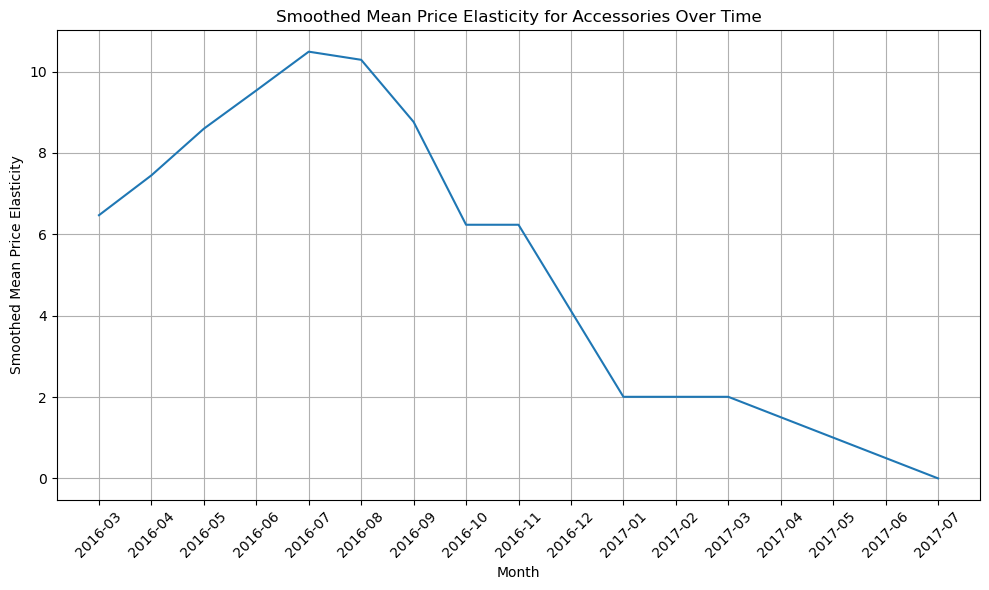

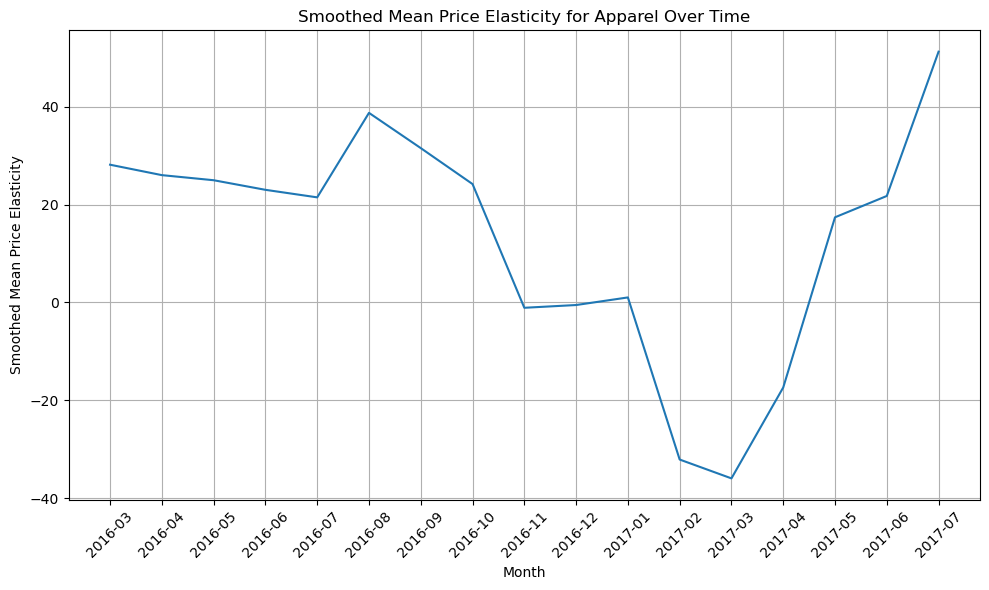

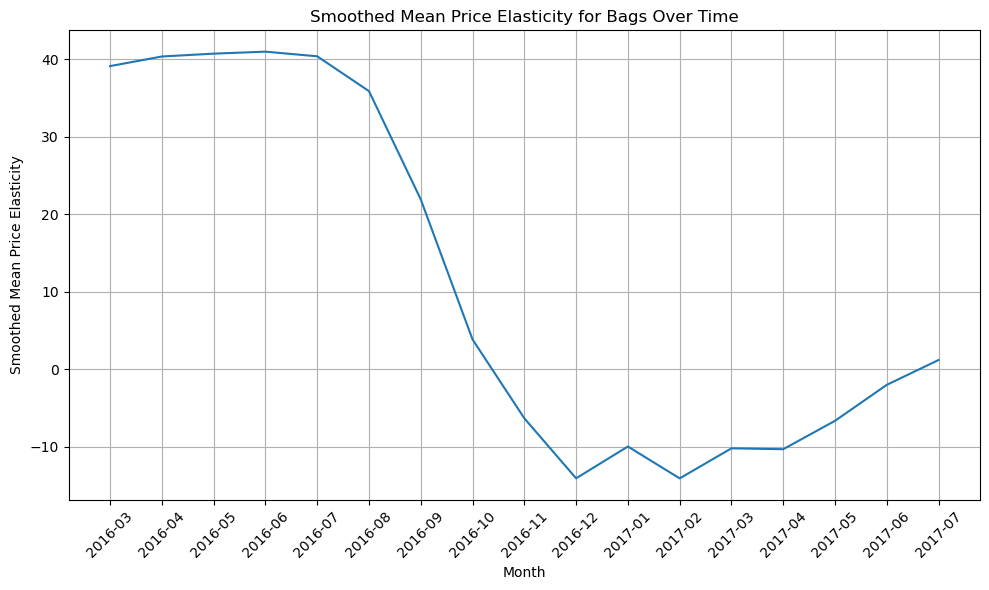

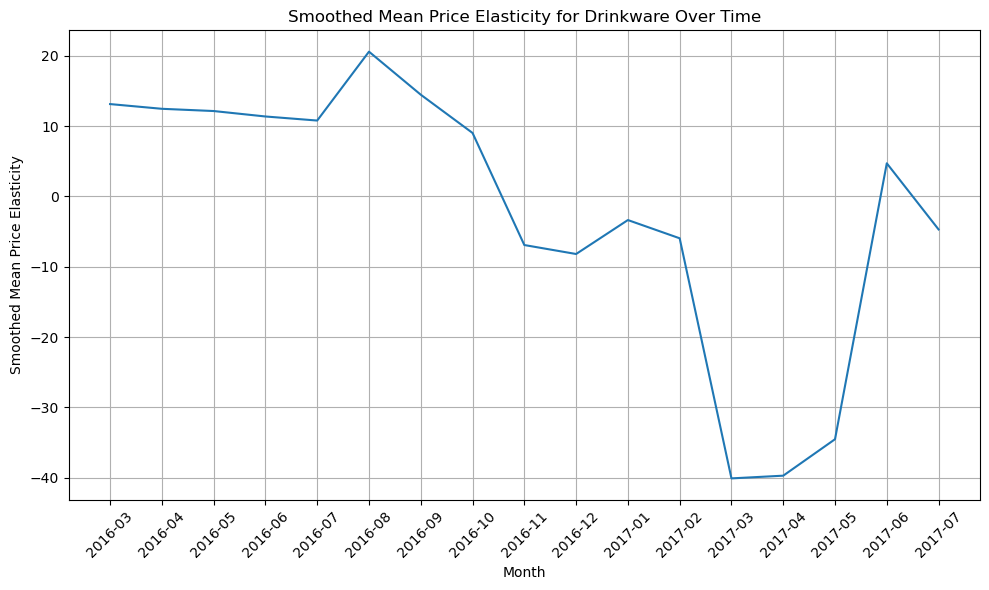

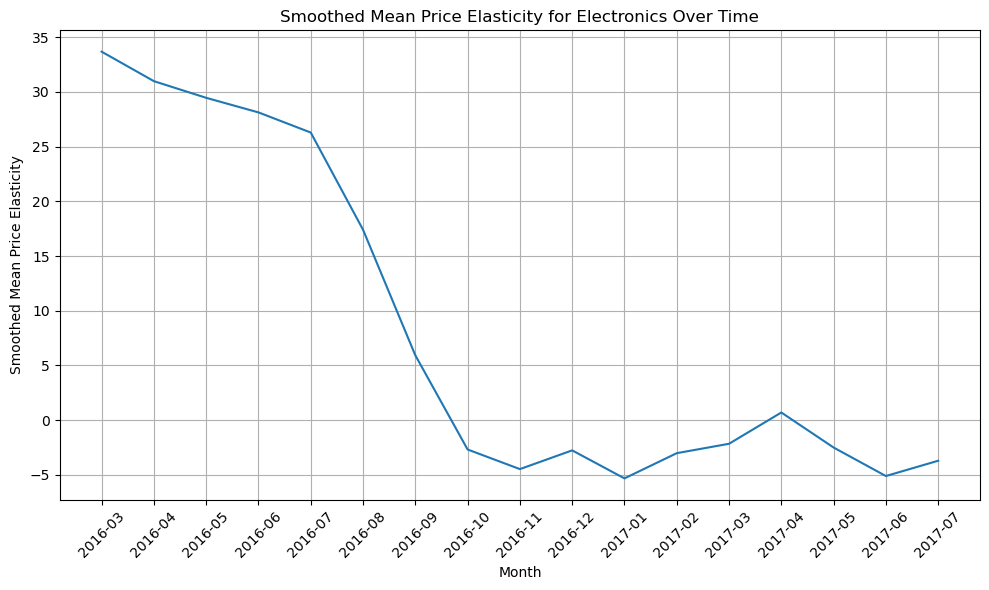

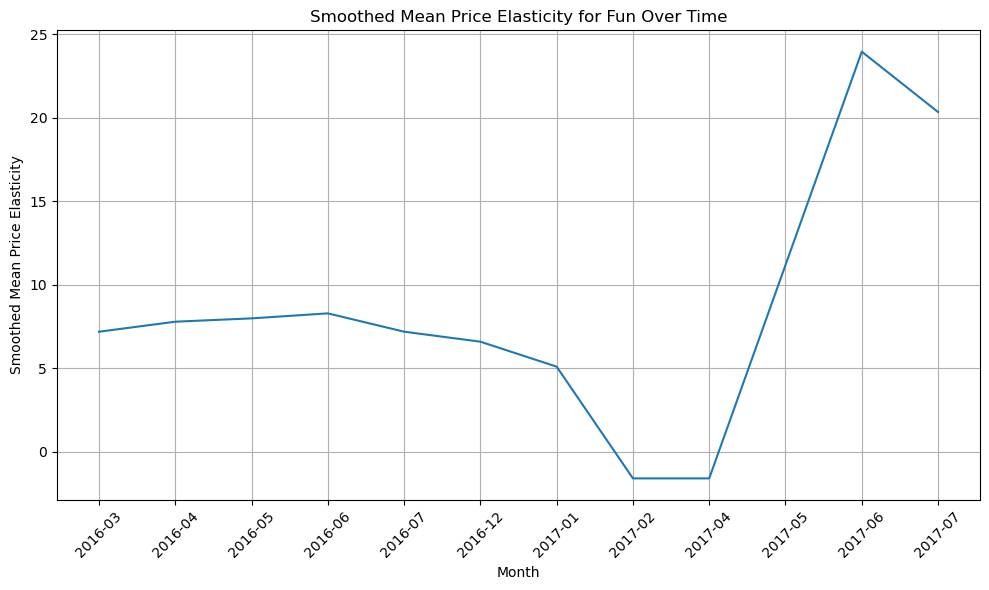

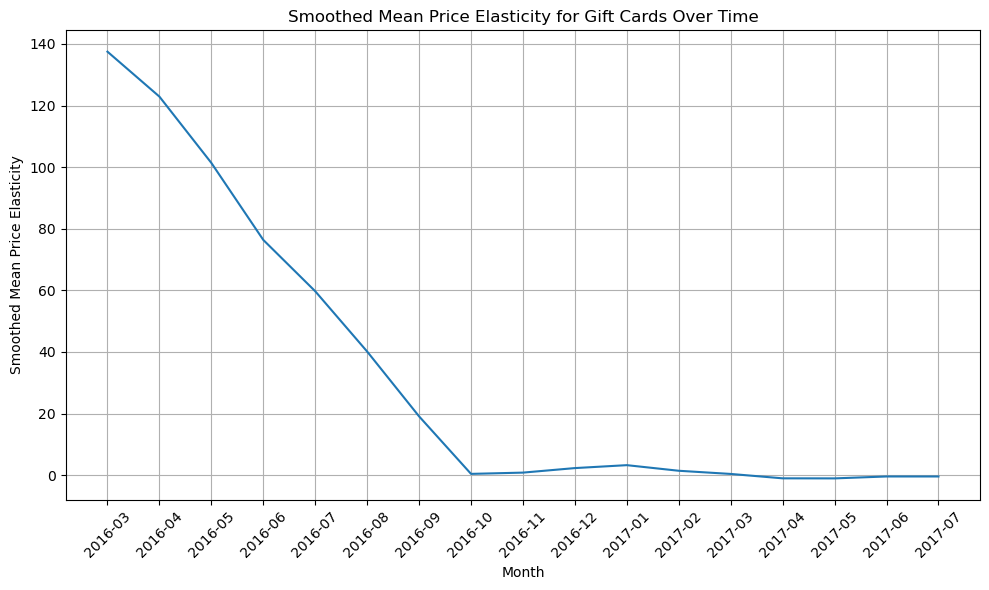

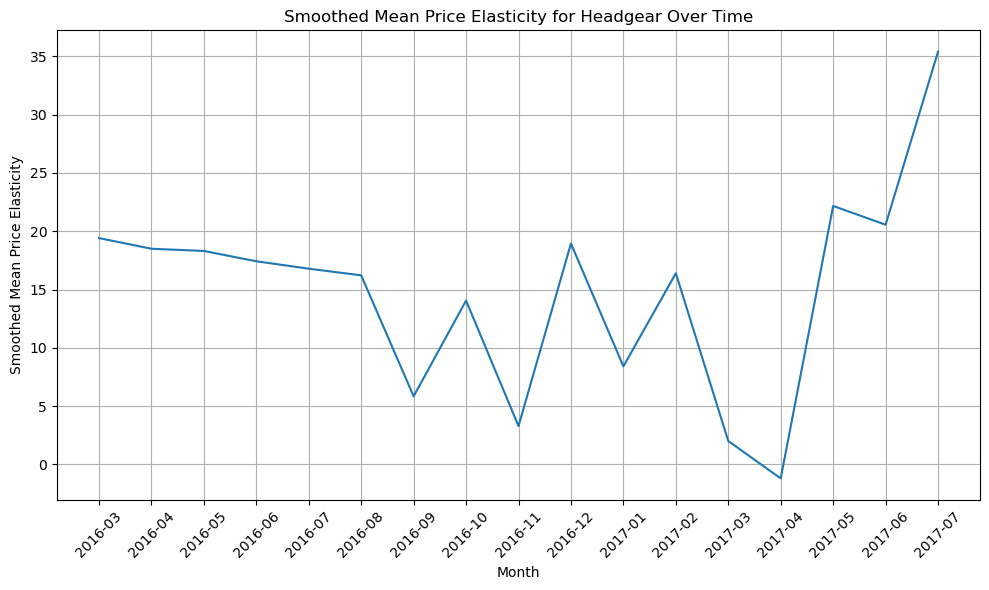

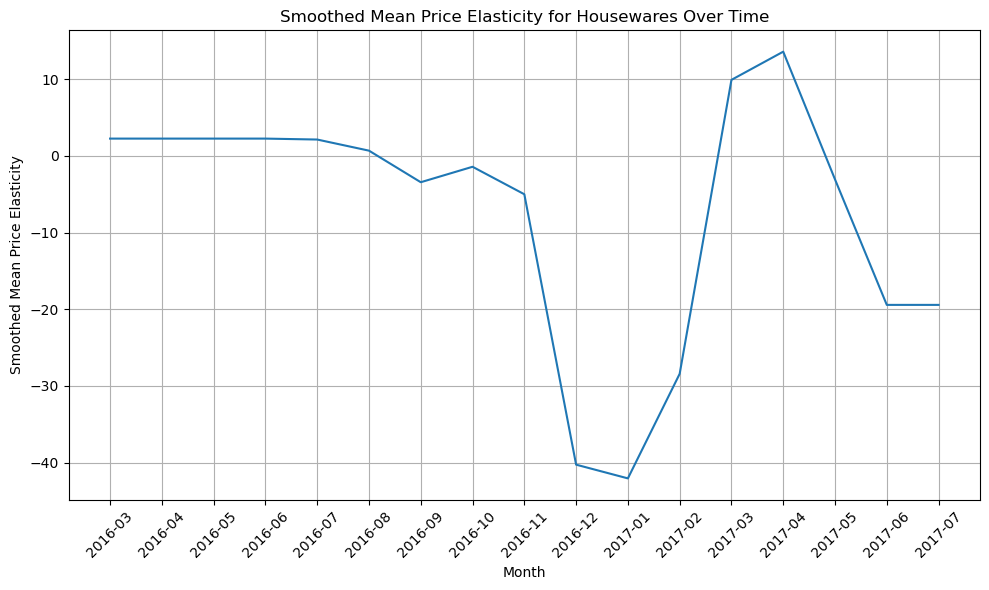

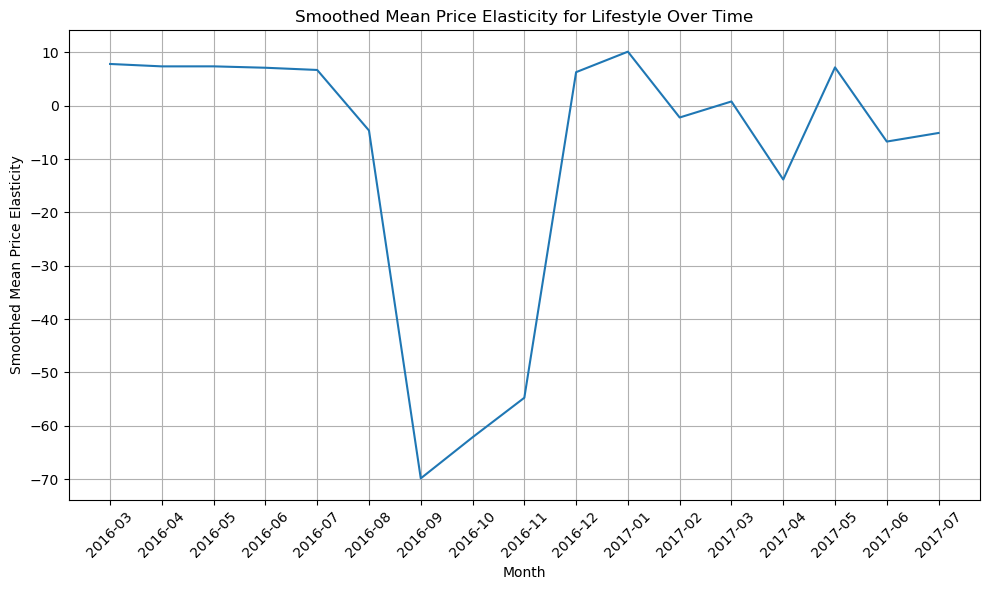

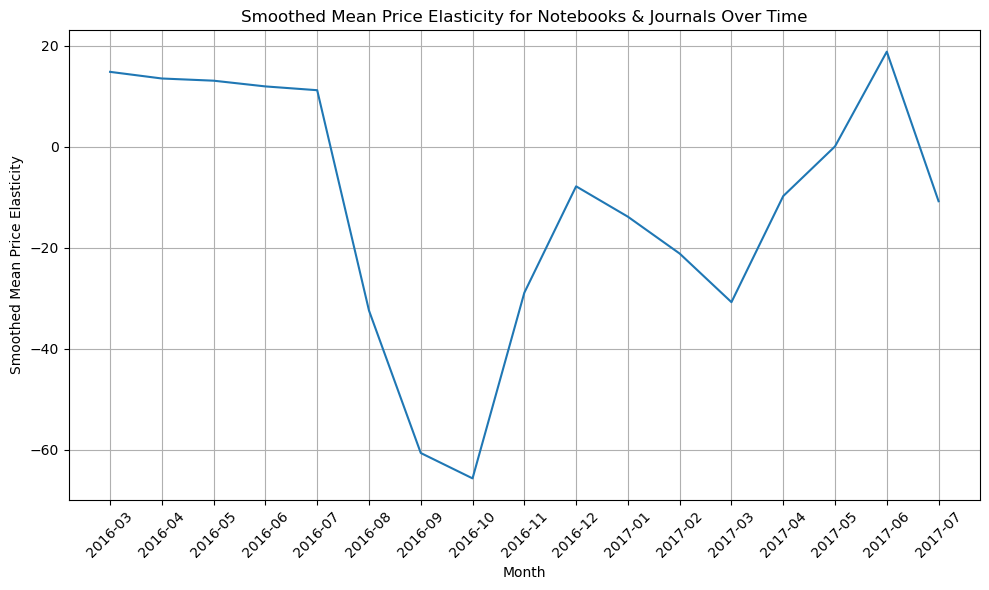

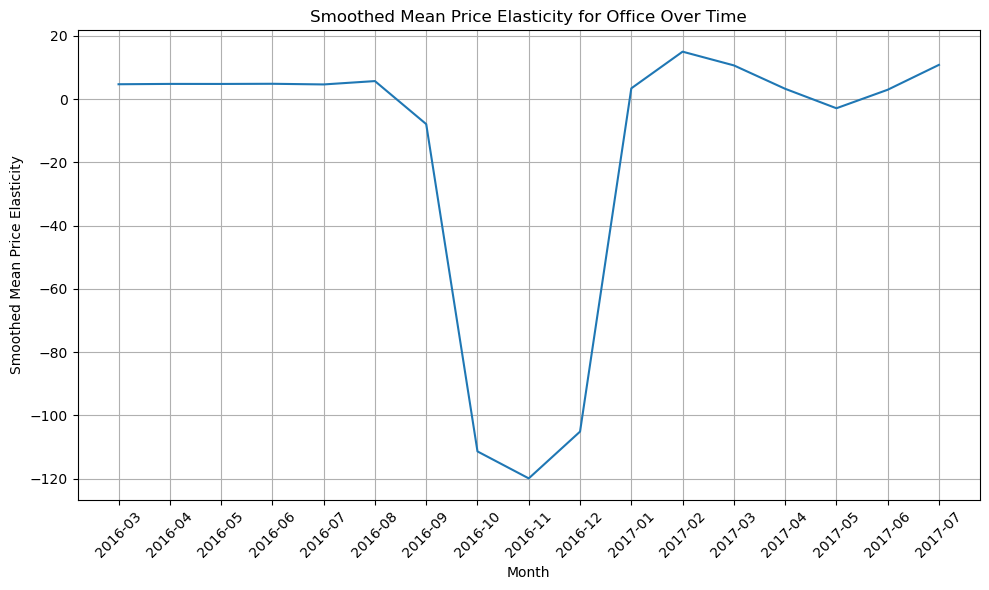

In [73]:
# Apply a rolling mean (moving average) to smooth out the fluctuations
combined_data['mean_price_elasticity_smoothed'] = combined_data.groupby('product_category')['mean_price_elasticity'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Plot the smoothed data for each product category
for category in product_categories:
    category_data = combined_data[combined_data['product_category'] == category]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=category_data, x='month', y='mean_price_elasticity_smoothed')
    
    # Add labels, title, and other formatting
    plt.title(f'Smoothed Mean Price Elasticity for {category} Over Time')
    plt.xlabel('Month')
    plt.ylabel('Smoothed Mean Price Elasticity')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Ensure a clean layout and display the plot
    plt.tight_layout()
    plt.show()

In [74]:
# Accessories have rising price elasticity from March 2016 and peaked at July 2016 before decreasing trend.
# Apparel have generally decreasing price elasticity until March 2017 then sharp increase. 
# Bags have general decreasing trend.
# Drinkware decreasing steadily until March 2017 where there is sharp increase.
# Electronics general decreasing trend.
# Fun products stable until sharp increase from April 2017.
# Gift cards sharp decrease then stable.
# Headgear volatile 
# Housewares generally stable with downs and ups from November 2016 to April 2017.
# Lifestyle dip from July to November 2016 before returning to normal levels.
# Notebooks and Journals volatile 
# Office stable then sharp decrease from September to December 2016 before returning to normal levels.